In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import seaborn as sns
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [5]:
# Load your dataset 
df = pd.read_csv('../src/data/raw_analyst_ratings.csv') 

print("Column names", df.columns)

df = df.drop(columns=['Unnamed: 0'])

print("Column names", df.columns)

Column names Index(['Unnamed: 0', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')
Column names Index(['headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


Basic data assessment

In [ ]:
# 1. Basic overview
print("Shape of the dataset:", df.shape)

print("\nFirst 5 rows:\n", df.head())

print("\nLast 5 rows:\n", df.tail())


In [ ]:
# 2. Data types and non-null counts
print("\nInfo about dataset:")
df.info()

In [ ]:
# 3. Summary statistics (numeric columns)
print("\nSummary statistics (numeric):")
print(df.describe())

# 4. Summary statistics (categorical columns)
print("\nSummary statistics (categorical):")
print(df.describe(include=['object', 'category']))

In [ ]:
print("unique company names" )
print(df['stock'].nunique())

print("Unique company tickers:")
print(df['stock'].unique())


In [ ]:
# Replace 'AAPL' with the ticker you're interested in
stock_name = 'TSLA'
df_stock = df[df['stock'] == stock_name]

# Display the first few rows
print(df_stock.head())
print(f"Number of articles for {stock_name}: {len(df_stock)}")


In [ ]:
# Define function to calculate polarity
def calculate_polarity(text):
    return TextBlob(text).sentiment.polarity

# Apply to headline column
df['Sentiment'] = df['headline'].apply(calculate_polarity)
df.head()

In [ ]:
# Display descriptive statistics for the 'headline' column
print("Descriptive statistics for 'headline' column:")
print(df['headline'].describe())

# Check for missing values in the 'headline' column
print("\nMissing values in 'headline' column:")
print(df['headline'].isnull().sum())

# Get the number of unique headlines
print("\nNumber of unique headlines:")
print(df['headline'].nunique())

# Display the most frequent headlines
print("\nMost frequent headlines:")
print(df['headline'].value_counts().head())



In [ ]:
# You can further analyze the distribution of sentiment scores calculated earlier
print("\nSentiment distribution:")
print(df['Sentiment'].describe())

# Plot the distribution of sentiment scores
plt.figure(figsize=(8, 4))
sns.histplot(df['Sentiment'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores for Headlines')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

# Analyze the sentiment of the most positive and negative headlines
most_positive_headlines = df.nlargest(5, 'Sentiment')
print("\nMost Positive Headlines:")
print(most_positive_headlines[['headline', 'Sentiment']])

most_negative_headlines = df.nsmallest(5, 'Sentiment')
print("\nMost Negative Headlines:")
print(most_negative_headlines[['headline', 'Sentiment']])

Text Analysis(Topic Modeling)

In [7]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mijuu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
headlines = df['headline'].dropna().astype(str).tolist()
# Preprocessing function
def preprocess(texts):
    stop_words = set(stopwords.words('english'))
    processed = []
    for line in texts:
        line = line.lower()
        line = line.translate(str.maketrans('', '', string.punctuation))
        words = [w for w in line.split() if w not in stop_words and w.isalpha()]
        processed.append(' '.join(words))
    return processed

cleaned_headlines = preprocess(headlines)

# Vectorize
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(cleaned_headlines)

# LDA model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Show topics
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic #{idx+1}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lda, vectorizer.get_feature_names_out())

Time Series Analysis:


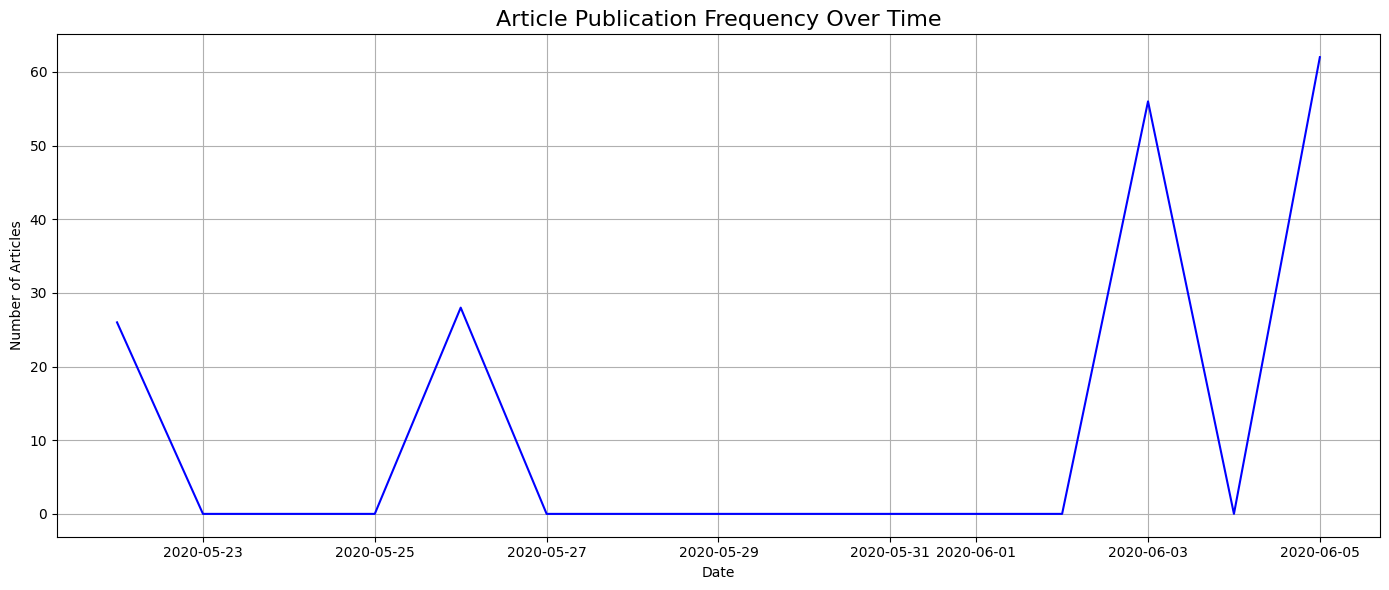

In [8]:
# Convert to datetime safely, force mixed format
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')

# Drop invalid datetimes 
df = df.dropna(subset=['date'])

#  Confirm dtype and remove timezone
if pd.api.types.is_datetime64_any_dtype(df['date']):
    # If timezone-aware, make it naive
    if df['date'].dt.tz is not None:
        df['date'] = df['date'].dt.tz_localize(None)
else:
    raise TypeError("The 'date' column is not datetime-like.")

# Set index and resample
df.set_index('date', inplace=True)

# Resample by day
daily_counts = df.resample('D').size()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(daily_counts, color='blue', linewidth=1.5)
plt.title("Article Publication Frequency Over Time", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.tight_layout()


plt.savefig("../images/sentiment/article_frequency_over_time.png", dpi=300)

plt.show()
